# DESOM from SOM-CPC paper: PyTorch & MNIST

[SOM file](https://github.com/IamHuijben/SOM-CPC/blob/main/modules/SOM.py)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from tqdm import trange
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle, functools

In [2]:
print(f"torch version: {torch.__version__}")

# Check if there are multiple devices (i.e., GPU cards)-
print(f"Number of GPU(s) available = {torch.cuda.device_count()}")

# Which GPU Is The Current GPU?
# print(f"current GPU: {torch.cuda.current_device()}")

# Get the name of the current GPU-
# print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")

# Is PyTorch using a GPU?
# print(f"Is PyTorch using a GPU? {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.current_device()}")
    print(f"Current GPU name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("PyTorch does not have access to GPU")

# Device configuration-
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Available device is {device}')

torch version: 2.0.1+cu117
Number of GPU(s) available = 1
Current GPU: 0
Current GPU name: NVIDIA GeForce GTX TITAN X
Available device is cuda


In [3]:
# Specify hyper-parameters-
num_epochs = 120
batch_size = 1024
learning_rate = 0.001

### MNIST Data Pre-processing

In [4]:
# Define transformations for MNIST dataset-
# MNIST dataset statistics-
mean = np.array([0.1307])
std_dev = np.array([0.3081])

transforms_apply = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(mean = mean, std = std_dev)
    ]
)

In [5]:
path_to_data = "/home/majumdar/Downloads/.data/"

# Load MNIST dataset-
train_dataset = torchvision.datasets.MNIST(
    # root = './data', train = True,
    root = path_to_data + "data", train = True,
    transform = transforms_apply, download = True
)

test_dataset = torchvision.datasets.MNIST(
    # root = './data', train = False,
    root = path_to_data + "data", train = False,
    transform = transforms_apply
)

In [6]:
# Create training and testing dataloaders-
train_loader = torch.utils.data.DataLoader(
    dataset = train_dataset, batch_size = batch_size,
    shuffle = True
)

test_loader = torch.utils.data.DataLoader(
    dataset = test_dataset, batch_size = batch_size,
    shuffle = False
)

### Conv-AE architecture

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, capacity):
        super().__init__()
        
        self.capacity = capacity
        self.latent_dim = latent_dim
        
        self.conv1 = nn.Conv2d(
            in_channels = 1, out_channels = self.capacity,
            kernel_size = 4, stride = 2,
            padding = 1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(
            in_channels = self.capacity, out_channels = self.capacity * 2,
            kernel_size = 4, stride = 2,
            padding = 1) # out: c x 7 x 7
        self.dense = nn.Linear(in_features = self.capacity * 2 * 7 * 7, out_features = 100)
        self.dense2 = nn.Linear(in_features = 100, out_features = self.latent_dim)
        
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x = F.relu(self.dense(x))
        x = F.relu(self.dense2(x))
        return x

    
class Decoder(nn.Module):
    def __init__(self, latent_dim, capacity):
        super().__init__()
        
        self.capacity = capacity
        self.latent_dim = latent_dim
        
        self.dense = nn.Linear(in_features = self.latent_dim, out_features = 100) 
        self.dense2 = nn.Linear(in_features = 100, out_features = self.capacity * 2 * 7 * 7)
        self.conv1 = nn.ConvTranspose2d(
            in_channels = self.capacity * 2, out_channels = self.capacity,
            kernel_size = 4, stride = 2,
            padding = 1
        )
        self.conv2 = nn.ConvTranspose2d(
            in_channels = self.capacity, out_channels = 1,
            kernel_size = 4, stride = 2, 
            padding = 1
        )
        
        
    def forward(self, x):
        x = self.dense(x)
        x = self.dense2(x)
        x = x.view(x.size(0), self.capacity * 2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv1(x))
        x = torch.sigmoid(self.conv2(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x
        

In [8]:
num_steps_per_epoch = int(np.ceil(len(train_dataset) / batch_size))

# max number of train iterations-
n_max = num_epochs * num_steps_per_epoch

In [9]:
# m = SOM height-
som_height = 20

# n = SOM width-
som_width = 20

latent_space_dim = 50

# initial width of gaussian blur. If None, half of the grid is used-
# sigma = 10.0

'''
if alpha is not None:
    alpha = torch.tensor(alpha)

if sigma is not None:
    sigma = torch.tensor(sigma)
else:
    sigma = np.sqrt(m * n) / 2.0
'''

# Initial standard deviation-
sigma_0 = torch.tensor(0.5 * np.sqrt(som_height * som_width))

# Choosing a lower value at the end of the training induced instable
# optimization behavior-
sigma_n_max = torch.tensor(2.0)
# Final std-dev

# Compute lambda value-
lmbda_val = -n_max / np.log(sigma_n_max / sigma_0)
# reqd for sigma decay

# Decay schedule-
sched = 'linear'

# metric = None
p_norm = 2
# centroids = None
grid_size = som_height * som_width


In [ ]:
# metric = functools.partial(torch.cdist, p = p_norm)

In [10]:
print(f"max number of train steps in {num_epochs} epochs = {num_steps_per_epoch}")

max number of train steps in 120 epochs = 59


### ```Embedding```

- A simple lookup table that stores embeddings of a fixed dictionary and size.

- This module is often used to store word embeddings and retrieve them using indices. The input to the module is a list of indices, and the output is the corresponding word embeddings.

[Reference](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html)

In [11]:
class SOM(nn.Module):
    def __init__(
        self, map_height = 10, map_width = 10,
        latent_dim = 50, p_norm = 2
    ):
        super().__init__()
        
        self.map_height = map_height
        self.map_width = map_width
        self.latent_dim = latent_dim
        self.p_norm = p_norm
        self.som_nodes = self.map_height * self.map_width

        # Uniform sampling for SOM (flattened) weights initialization-
        # self.som_wts = torch.distributions.uniform.Uniform(low = - 1 / np.sqrt(latent_space_dim), high = 1 / np.sqrt(latent_space_dim)).sample((m * n, latent_space_dim))

        # create the embedding dictionary-
        # self.embedding = nn.Embedding(self.som_nodes, self.latent_dim)
        # self.embedding.weight.data.uniform_(-np.sqrt(1 / self.latent_dim), np.sqrt(1 / self.latent_dim))

        # Create SOM using linear layer (without bias)-
        self.som_wts = nn.Linear(in_features = self.latent_dim, out_features = self.map_height * self.map_width, bias = False)
        self.som_wts.weight.data.uniform_(-np.sqrt(1 / self.latent_dim), np.sqrt(1 / self.latent_dim))


    def forward(self):
        pass
        

In [12]:
class DESOM(nn.Module):
    def __init__(
        self, latent_dim = 50,
        capacity = 16, map_height = 10,
        map_width = 10, p_norm = 2,
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.capacity = capacity
        self.map_height = map_height
        self.map_width = map_width
        self.p_norm = p_norm

        # tot_train_iterations = num_epochs * len(train_loader)
        # self.decay_vals = list(scheduler(it = step, tot = tot_train_iterations) for step in range(1, tot_train_iterations + 6))
        # self.decay_vals = torch.tensor(np.asarray(decay_vals))

        self.encoder = Encoder(latent_dim = self.latent_dim, capacity = self.capacity)
        self.decoder = Decoder(latent_dim = self.latent_dim, capacity = self.capacity)
        self.som = SOM(map_height = self.map_height, map_width = self.map_width, p_norm = self.p_norm)


    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return z, x_recon


    

In [13]:
# Initialize DESOM model-
model = DESOM(
    latent_dim = latent_space_dim, capacity = 16,
    map_height = som_height, map_width = som_width,
    p_norm = p_norm
)

In [14]:
# Move to device-
model = model.to(device)

In [15]:
model.som.som_wts.weight.shape
# model.som.embedding.weight.shape

torch.Size([400, 50])

In [16]:
# som.som_wts.min(), som.som_wts.max()
# model.som.embedding.weight.min().item(), model.som.embedding.weight.max().item()
model.som.som_wts.weight.min().item(), model.som.som_wts.weight.max().item()

(-0.14141587913036346, 0.14140239357948303)

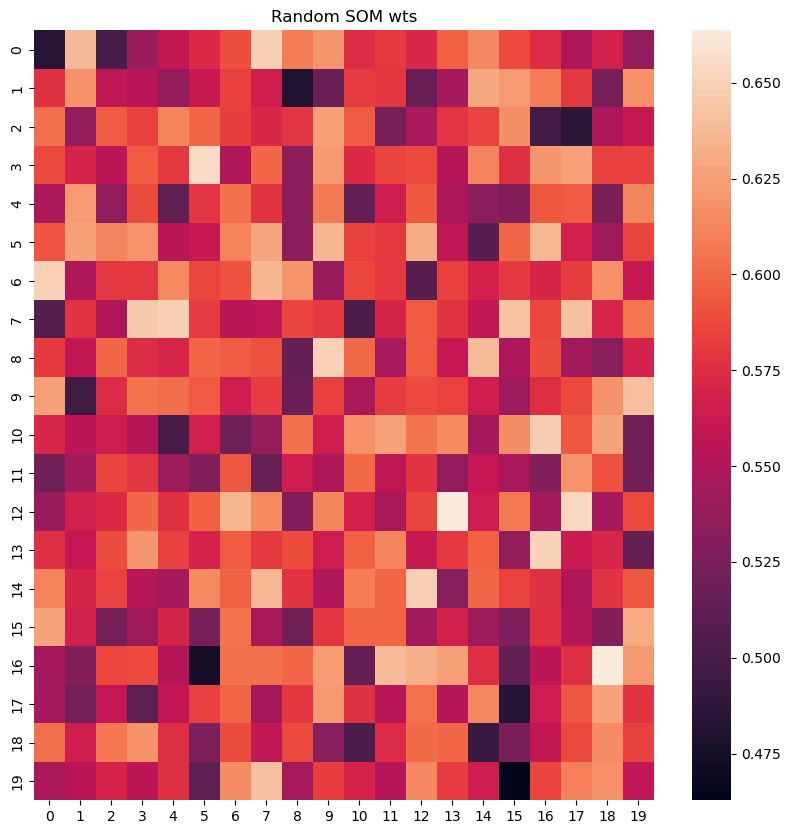

In [17]:
plt.figure(figsize = (10, 10))
sns.heatmap(data = torch.norm(input = model.som.som_wts.weight.reshape(som_height, som_width, -1).detach().cpu(), p = 'fro', dim = 2))
plt.title("Random SOM wts")
plt.show()

In [ ]:
'''
def scheduler(it, tot):
    if sched == 'linear':
        return 1.0 - it / tot
    # half the lr 20 times
    if sched == 'half':
        return 0.5 ** int(20 * it / tot)
    # decay from 1 to exp(-5)
    if sched == 'exp':
        return np.exp(-5 * it / tot)
    
    raise NotImplementedError('Wrong value of "sched"')
''' 

In [21]:
# Compute sigma for nth train step- 
lmbda_values = list(sigma_0 * np.exp(-n / lmbda_val) for n in range(1, n_max))
lmbda_values = np.array(lmbda_values)

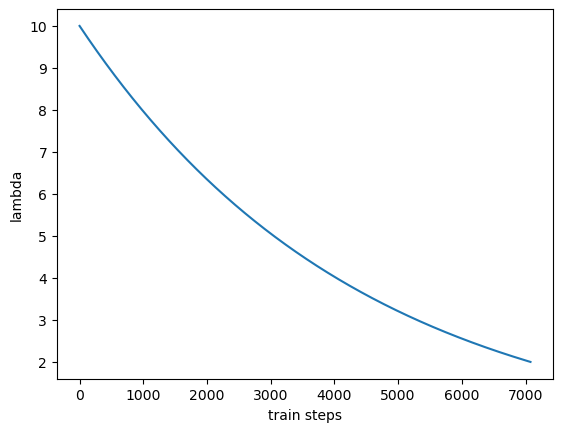

In [22]:
plt.plot(lmbda_values)
plt.xlabel("train steps")
plt.ylabel("lambda")
plt.show()

In [23]:
del lmbda_values

In [ ]:
'''
def get_bmu_distance_squares(bmu_loc):
    bmu_loc = bmu_loc.unsqueeze(0).expand_as(locations).float()
    bmu_distance_squares = torch.sum(torch.pow(locations.float() - bmu_loc, 2), 1)
    return bmu_distance_squares
'''

In [18]:
locs = [np.array([i, j]) for i in range(som_height) for j in range(som_width)]
# locations = torch.LongTensor(np.array(locs)).to(device)
# locations = torch.LongTensor(np.array(locs))
locations = torch.from_numpy(np.array(locs)).to(torch.float32).to(device)
del locs

# distance_mat = torch.stack([get_bmu_distance_squares(loc) for loc in locations]).to(torch.float32)

In [19]:
# locations.shape, distance_mat.shape
# (torch.Size([400, 2]), torch.Size([400, 400]))

locations.shape

torch.Size([400, 2])

In [20]:
# Count number of layer-wise parameters and total parameters-
tot_params = 0
for param in model.parameters():
    print(f"layer.shape = {param.shape} has {param.nelement()} parameters")
    tot_params += param.nelement()

print(f"\nTotal number of parameters in Conv-AE SOM model = {tot_params}")
del param

layer.shape = torch.Size([16, 1, 4, 4]) has 256 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([32, 16, 4, 4]) has 8192 parameters
layer.shape = torch.Size([32]) has 32 parameters
layer.shape = torch.Size([100, 1568]) has 156800 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([50, 100]) has 5000 parameters
layer.shape = torch.Size([50]) has 50 parameters
layer.shape = torch.Size([100, 50]) has 5000 parameters
layer.shape = torch.Size([100]) has 100 parameters
layer.shape = torch.Size([1568, 100]) has 156800 parameters
layer.shape = torch.Size([1568]) has 1568 parameters
layer.shape = torch.Size([32, 16, 4, 4]) has 8192 parameters
layer.shape = torch.Size([16]) has 16 parameters
layer.shape = torch.Size([16, 1, 4, 4]) has 256 parameters
layer.shape = torch.Size([1]) has 1 parameters
layer.shape = torch.Size([400, 50]) has 20000 parameters

Total number of parameters in Conv-AE SOM model = 362379


In [21]:
# Define gradient descent optimizer-
optimizer = torch.optim.Adam(
    params = model.parameters(),
    # params = som.parameters(),
    lr = 0.001, weight_decay = 5e-4
)

In [22]:
# Trade-off hyper-param-
gamma = 0.001

# Compute std-dev decay per train step/iteration-
step = 1

In [ ]:
'''
plt.plot(squared_l2_norm_dists[10].detach().cpu())
plt.axvline(x = bmu_indices[10].detach().cpu(), c = 'r')
plt.show()

plt.plot(topo_neighb[10].detach().cpu())
plt.axvline(x = bmu_indices[10].detach().cpu(), c = 'r')
plt.show()
'''

In [ ]:
'''
def train_one_epoch(
    model, dataloader,
    train_dataset, total_steps,
    # gamma = 0.001, p_norm = 2
):
    
    # Place model to device-
    model.to(device)
    
    # Enable training mode-
    model.train()
    
    # Initialize variables to reconstruction loss-
    running_recon_loss = 0.0
    running_topo_error = 0.0
    
    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
        ):

        x, _ = data
        
        # Push data samples to device-
        x = x.to(device)
        
        # Empty accumulated gradients-
        optimizer.zero_grad()

        # Get latent 'z' and reconstructed input data-
        z, x_recon = model(x)

        # Compute AE's reconstruction/task loss-
        recon_loss = F.mse_loss(input = x, target = x_recon)


        # DESOM training code:

        # Perform Lp normalization of inputs over specified dimension-
        # z = F.normalize(input = z, p = p_norm, dim = 1)
        # L2-normalize each input (for SOM's uniform wts initialization)
        
        # Compute dist b/w 'z' & all other SOM units-
        dists = torch.cdist(x1 = z, x2 = model.som.embedding.weight, p = p_norm)
        
        # Compute min dist for each input in batch and its BMUs-
        mindist, bmu_indices = torch.min(dists, -1)

        # dists.shape, mindist.shape
        # (torch.Size([1024, 400]), torch.Size([1024]))
        
        # Find BMU locations-
        bmu_locs = locations[bmu_indices]
        
        # Squared Euclidean/L2 distance b/w: BMU & SOM units-
        squared_l2_dist_bmu_soms = torch.square(torch.cdist(x1 = bmu_locs, x2 = locations, p = p_norm))

        global step
        # sigma_curr_val = decay_vals[step] * sigma
        sigma_curr_val = (1.0 - (step / tot_train_iterations)) * sigma
        step += 1
        
        # Topographic neighborhood structure promoted bia a
        # neighborhood kernel 'S'
        topo_neigh_struture = torch.exp(-squared_l2_dist_bmu_soms / (2 * torch.square(sigma_curr_val) + 1e-6))
        # A Gaussian kernel is often used!
        
        # Compute topographic loss-
        topo_loss = torch.square(dists) * topo_neigh_struture
        topo_loss = topo_loss.sum(1).mean()

        # Compute total loss-
        total_loss = recon_loss + (gamma * topo_loss)

        # Compute gradienst wrt computed loss-
        total_loss.backward()
        
        # Perform one step of gradient descent-
        optimizer.step()
        
        # Compute total reconstruction loss-
        running_recon_loss += recon_loss.item()
        running_topo_error += topo_loss.item()

        del x, z, x_recon, topo_loss, recon_loss, total_loss
        
    # Compute loss as float value-
    recon_loss = running_recon_loss / len(dataloader.dataset)
    topo_loss = running_topo_error / len(dataloader.dataset)

    return recon_loss, topo_loss, sigma_curr_val
'''

In [23]:
def train_one_epoch(
    model, dataloader,
    train_dataset
):
    model.train()

    running_recon_loss = 0.0
    running_topo_loss = 0.0

    for i, data in tqdm(
        enumerate(dataloader),
        total = int(len(train_dataset) / dataloader.batch_size)
    ):
        x, _ = data
        x = x.to(device)

        z, x_recon = model(x)

        optimizer.zero_grad()

        recon_loss = F.mse_loss(input = x_recon, target = x)

        # l2_dist_z_soms = torch.cdist(x1 = z, x2 = model.som.embedding.weight, p = p_norm)
        l2_dist_z_soms = torch.cdist(x1 = z, x2 = model.som.som_wts.weight, p = p_norm)
        mindist, bmu_indices = torch.min(l2_dist_z_soms, -1)
        bmu_locations = locations[bmu_indices]
        squared_l2_norm_dists = torch.square(torch.cdist(x1 = bmu_locations, x2 = locations, p = p_norm))

        # Compute sigma for current iteration/step-
        global step
        curr_sigma_val = sigma_0 * torch.exp(-step / lmbda_val)
        step += 1

        topo_neighb = torch.exp(-squared_l2_norm_dists / ((2 * torch.square(curr_sigma_val)) + 1e-6))

        topo_loss = topo_neighb * squared_l2_norm_dists
        topo_loss = topo_loss.sum(1).mean()

        # Compute total loss-
        total_loss = recon_loss + (gamma * topo_loss)

        # Compute gradienst wrt computed loss-
        total_loss.backward()
        
        # Perform one step of gradient descent-
        optimizer.step()
        
        # Compute total reconstruction loss-
        running_recon_loss += recon_loss.item()
        running_topo_loss += topo_loss.item()

        del x, z, x_recon, topo_loss, recon_loss, total_loss
        
    # Compute loss as float value-
    recon_loss = running_recon_loss / len(dataloader.dataset)
    topo_loss = running_topo_loss / len(dataloader.dataset)

    return recon_loss, topo_loss, curr_sigma_val.item()
    

In [24]:
def test_one_epoch(model, dataloader, test_dataset):
    
    # Place model to device-
    model.to(device)
    
    # Enable evaluation mode-
    model.eval()
    
    running_recon_loss = 0.0
    
    with torch.no_grad():
        for i, data in tqdm(
            enumerate(dataloader),
            total = int(len(test_dataset) / test_loader.batch_size)
        ):
            x, _ = data
        
            # Push data points to 'device'-
            x = x.to(device)
            
            # Forward propagation-
            _, x_recon = model(x)
            
            # Compute reconstruction loss-
            recon_loss = F.mse_loss(input = x, target = x_recon)
            
            # Compute total reconstruction loss-
            running_recon_loss += recon_loss.item()

            del x, x_recon, recon_loss
                
    test_recon_loss = running_recon_loss / len(dataloader.dataset)
    
    return test_recon_loss

In [ ]:
'''
recon_train_loss, topo_train_loss, curr_sigma_val = train_one_epoch(
    model = model, dataloader = train_loader,
    train_dataset = train_dataset
)

recon_test_loss = test_one_epoch(
    model = model, dataloader = test_loader,
    test_dataset = test_dataset
)
'''

In [25]:
# Python dict to contain training metrics-
train_history = {}

# To save 'best' parameters-
best_test_loss = 10000

In [ ]:
# step = 1

In [26]:
for epoch in range(1, num_epochs + 1):
    
    # Train model for 1 epoch-
    recon_train_loss, topo_train_loss, curr_sigma_val = train_one_epoch(
        model = model, dataloader = train_loader,
        train_dataset = train_dataset
    )

    recon_test_loss = test_one_epoch(
        model = model, dataloader = test_loader,
        test_dataset = test_dataset
    )
    
    # Store model performance metrics in Python3 dict-
    train_history[epoch] = {
        'train_recon_loss': recon_train_loss,
        'train_topo_loss': topo_train_loss,
        'test_recon_loss': recon_test_loss
    }
    
    print(f"Epoch = {epoch}; train MSE loss = {recon_train_loss:.6f}, ",
          f" topo loss = {gamma * topo_train_loss:.6f}, test MSE loss = {recon_test_loss:.6f},"
          f" L2-norm = {torch.norm(input = model.som.som_wts.weight, p = p_norm).item():.6f}"
          f"; sigma_curr_val = {curr_sigma_val:.7f}"
         )

    if recon_test_loss < best_test_loss:
        best_test_loss = recon_test_loss
        print(f"Saving model with lowest test_loss = {recon_test_loss:.6f}\n")
        
        # Save trained model with 'best' validation accuracy-
        torch.save(model.state_dict(), "DESOM_MNIST_best_model.pth")
 

59it [00:12,  4.88it/s]                                                                                                                                                
10it [00:01,  5.36it/s]                                                                                                                                                


Epoch = 1; train MSE loss = 0.000891,   topo loss = 0.021298, test MSE loss = 0.000816, L2-norm = 11.542783; sigma_curr_val = 9.8667756
Saving model with lowest test_loss = 0.000816



59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 2; train MSE loss = 0.000747,   topo loss = 0.020694, test MSE loss = 0.000693, L2-norm = 11.542783; sigma_curr_val = 9.7353260
Saving model with lowest test_loss = 0.000693



59it [00:11,  5.24it/s]                                                                                                                                                
10it [00:01,  5.40it/s]                                                                                                                                                


Epoch = 3; train MSE loss = 0.000646,   topo loss = 0.020028, test MSE loss = 0.000636, L2-norm = 11.542783; sigma_curr_val = 9.6056277
Saving model with lowest test_loss = 0.000636



59it [00:11,  5.11it/s]                                                                                                                                                
10it [00:02,  4.93it/s]                                                                                                                                                


Epoch = 4; train MSE loss = 0.000610,   topo loss = 0.019451, test MSE loss = 0.000611, L2-norm = 11.542783; sigma_curr_val = 9.4776573
Saving model with lowest test_loss = 0.000611



59it [00:11,  5.21it/s]                                                                                                                                                
10it [00:01,  5.39it/s]                                                                                                                                                


Epoch = 5; train MSE loss = 0.000590,   topo loss = 0.018889, test MSE loss = 0.000593, L2-norm = 11.542783; sigma_curr_val = 9.3513917
Saving model with lowest test_loss = 0.000593



59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.40it/s]                                                                                                                                                


Epoch = 6; train MSE loss = 0.000571,   topo loss = 0.018349, test MSE loss = 0.000576, L2-norm = 11.542783; sigma_curr_val = 9.2268083
Saving model with lowest test_loss = 0.000576



59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.42it/s]                                                                                                                                                


Epoch = 7; train MSE loss = 0.000556,   topo loss = 0.017794, test MSE loss = 0.000564, L2-norm = 11.542783; sigma_curr_val = 9.1038847
Saving model with lowest test_loss = 0.000564



59it [00:11,  5.14it/s]                                                                                                                                                
10it [00:01,  5.16it/s]                                                                                                                                                


Epoch = 8; train MSE loss = 0.000546,   topo loss = 0.017244, test MSE loss = 0.000555, L2-norm = 11.542783; sigma_curr_val = 8.9825987
Saving model with lowest test_loss = 0.000555



59it [00:11,  5.22it/s]                                                                                                                                                
10it [00:01,  5.35it/s]                                                                                                                                                


Epoch = 9; train MSE loss = 0.000540,   topo loss = 0.016708, test MSE loss = 0.000552, L2-norm = 11.542783; sigma_curr_val = 8.8629286
Saving model with lowest test_loss = 0.000552



59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.24it/s]                                                                                                                                                


Epoch = 10; train MSE loss = 0.000536,   topo loss = 0.016181, test MSE loss = 0.000547, L2-norm = 11.542783; sigma_curr_val = 8.7448527
Saving model with lowest test_loss = 0.000547



59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 11; train MSE loss = 0.000530,   topo loss = 0.015661, test MSE loss = 0.000541, L2-norm = 11.542783; sigma_curr_val = 8.6283499
Saving model with lowest test_loss = 0.000541



59it [00:11,  5.16it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 12; train MSE loss = 0.000525,   topo loss = 0.015146, test MSE loss = 0.000539, L2-norm = 11.542783; sigma_curr_val = 8.5133992
Saving model with lowest test_loss = 0.000539



59it [00:11,  5.12it/s]                                                                                                                                                
10it [00:01,  5.28it/s]                                                                                                                                                


Epoch = 13; train MSE loss = 0.000522,   topo loss = 0.014644, test MSE loss = 0.000533, L2-norm = 11.542783; sigma_curr_val = 8.3999800
Saving model with lowest test_loss = 0.000533



59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.50it/s]                                                                                                                                                


Epoch = 14; train MSE loss = 0.000520,   topo loss = 0.014151, test MSE loss = 0.000533, L2-norm = 11.542783; sigma_curr_val = 8.2880717
Saving model with lowest test_loss = 0.000533



59it [00:11,  5.11it/s]                                                                                                                                                
10it [00:01,  5.45it/s]                                                                                                                                                


Epoch = 15; train MSE loss = 0.000518,   topo loss = 0.013668, test MSE loss = 0.000530, L2-norm = 11.542783; sigma_curr_val = 8.1776543
Saving model with lowest test_loss = 0.000530



59it [00:11,  5.21it/s]                                                                                                                                                
10it [00:01,  5.51it/s]                                                                                                                                                


Epoch = 16; train MSE loss = 0.000516,   topo loss = 0.013195, test MSE loss = 0.000529, L2-norm = 11.542783; sigma_curr_val = 8.0687080
Saving model with lowest test_loss = 0.000529



59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 17; train MSE loss = 0.000515,   topo loss = 0.012732, test MSE loss = 0.000528, L2-norm = 11.542783; sigma_curr_val = 7.9612131
Saving model with lowest test_loss = 0.000528



59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.41it/s]                                                                                                                                                


Epoch = 18; train MSE loss = 0.000514,   topo loss = 0.012279, test MSE loss = 0.000527, L2-norm = 11.542783; sigma_curr_val = 7.8551503
Saving model with lowest test_loss = 0.000527



59it [00:11,  5.08it/s]                                                                                                                                                
10it [00:01,  5.45it/s]                                                                                                                                                


Epoch = 19; train MSE loss = 0.000512,   topo loss = 0.011837, test MSE loss = 0.000525, L2-norm = 11.542783; sigma_curr_val = 7.7505005
Saving model with lowest test_loss = 0.000525



59it [00:11,  5.22it/s]                                                                                                                                                
10it [00:01,  5.37it/s]                                                                                                                                                


Epoch = 20; train MSE loss = 0.000511,   topo loss = 0.011403, test MSE loss = 0.000524, L2-norm = 11.542783; sigma_curr_val = 7.6472449
Saving model with lowest test_loss = 0.000524



59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.40it/s]                                                                                                                                                


Epoch = 21; train MSE loss = 0.000510,   topo loss = 0.010980, test MSE loss = 0.000522, L2-norm = 11.542783; sigma_curr_val = 7.5453649
Saving model with lowest test_loss = 0.000522



59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 22; train MSE loss = 0.000508,   topo loss = 0.010567, test MSE loss = 0.000521, L2-norm = 11.542783; sigma_curr_val = 7.4448422
Saving model with lowest test_loss = 0.000521



59it [00:11,  5.25it/s]                                                                                                                                                
10it [00:01,  5.56it/s]                                                                                                                                                


Epoch = 23; train MSE loss = 0.000507,   topo loss = 0.010165, test MSE loss = 0.000521, L2-norm = 11.542783; sigma_curr_val = 7.3456588
Saving model with lowest test_loss = 0.000521



59it [00:11,  5.30it/s]                                                                                                                                                
10it [00:01,  5.56it/s]                                                                                                                                                


Epoch = 24; train MSE loss = 0.000507,   topo loss = 0.009773, test MSE loss = 0.000521, L2-norm = 11.542783; sigma_curr_val = 7.2477966
Saving model with lowest test_loss = 0.000521



59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 25; train MSE loss = 0.000506,   topo loss = 0.009394, test MSE loss = 0.000518, L2-norm = 11.542783; sigma_curr_val = 7.1512383
Saving model with lowest test_loss = 0.000518



59it [00:11,  5.22it/s]                                                                                                                                                
10it [00:01,  5.48it/s]                                                                                                                                                


Epoch = 26; train MSE loss = 0.000505,   topo loss = 0.009021, test MSE loss = 0.000518, L2-norm = 11.542783; sigma_curr_val = 7.0559663
Saving model with lowest test_loss = 0.000518



59it [00:11,  5.30it/s]                                                                                                                                                
10it [00:01,  5.50it/s]                                                                                                                                                


Epoch = 27; train MSE loss = 0.000505,   topo loss = 0.008665, test MSE loss = 0.000518, L2-norm = 11.542783; sigma_curr_val = 6.9619636
Saving model with lowest test_loss = 0.000518



59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 28; train MSE loss = 0.000504,   topo loss = 0.008315, test MSE loss = 0.000517, L2-norm = 11.542783; sigma_curr_val = 6.8692133
Saving model with lowest test_loss = 0.000517



59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 29; train MSE loss = 0.000504,   topo loss = 0.007976, test MSE loss = 0.000518, L2-norm = 11.542783; sigma_curr_val = 6.7776986


59it [00:11,  5.28it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 30; train MSE loss = 0.000503,   topo loss = 0.007654, test MSE loss = 0.000516, L2-norm = 11.542783; sigma_curr_val = 6.6874030
Saving model with lowest test_loss = 0.000516



59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.55it/s]                                                                                                                                                


Epoch = 31; train MSE loss = 0.000503,   topo loss = 0.007335, test MSE loss = 0.000516, L2-norm = 11.542783; sigma_curr_val = 6.5983105
Saving model with lowest test_loss = 0.000516



59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 32; train MSE loss = 0.000502,   topo loss = 0.007026, test MSE loss = 0.000515, L2-norm = 11.542783; sigma_curr_val = 6.5104049
Saving model with lowest test_loss = 0.000515



59it [00:11,  5.25it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 33; train MSE loss = 0.000502,   topo loss = 0.006729, test MSE loss = 0.000515, L2-norm = 11.542783; sigma_curr_val = 6.4236704
Saving model with lowest test_loss = 0.000515



59it [00:11,  5.30it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 34; train MSE loss = 0.000502,   topo loss = 0.006441, test MSE loss = 0.000515, L2-norm = 11.542783; sigma_curr_val = 6.3380914
Saving model with lowest test_loss = 0.000515



59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 35; train MSE loss = 0.000502,   topo loss = 0.006166, test MSE loss = 0.000514, L2-norm = 11.542783; sigma_curr_val = 6.2536526
Saving model with lowest test_loss = 0.000514



59it [00:11,  5.07it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 36; train MSE loss = 0.000501,   topo loss = 0.005902, test MSE loss = 0.000514, L2-norm = 11.542783; sigma_curr_val = 6.1703386
Saving model with lowest test_loss = 0.000514



59it [00:11,  5.01it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 37; train MSE loss = 0.000501,   topo loss = 0.005645, test MSE loss = 0.000514, L2-norm = 11.542783; sigma_curr_val = 6.0881346


59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.70it/s]                                                                                                                                                


Epoch = 38; train MSE loss = 0.000500,   topo loss = 0.005399, test MSE loss = 0.000513, L2-norm = 11.542783; sigma_curr_val = 6.0070258
Saving model with lowest test_loss = 0.000513



59it [00:10,  5.37it/s]                                                                                                                                                
10it [00:01,  5.69it/s]                                                                                                                                                


Epoch = 39; train MSE loss = 0.000500,   topo loss = 0.005163, test MSE loss = 0.000513, L2-norm = 11.542783; sigma_curr_val = 5.9269976
Saving model with lowest test_loss = 0.000513



59it [00:11,  5.27it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 40; train MSE loss = 0.000500,   topo loss = 0.004938, test MSE loss = 0.000513, L2-norm = 11.542783; sigma_curr_val = 5.8480355


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 41; train MSE loss = 0.000499,   topo loss = 0.004720, test MSE loss = 0.000512, L2-norm = 11.542783; sigma_curr_val = 5.7701254
Saving model with lowest test_loss = 0.000512



59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.49it/s]                                                                                                                                                


Epoch = 42; train MSE loss = 0.000500,   topo loss = 0.004517, test MSE loss = 0.000513, L2-norm = 11.542783; sigma_curr_val = 5.6932532


59it [00:11,  5.25it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 43; train MSE loss = 0.000499,   topo loss = 0.004318, test MSE loss = 0.000512, L2-norm = 11.542783; sigma_curr_val = 5.6174052
Saving model with lowest test_loss = 0.000512



59it [00:11,  4.92it/s]                                                                                                                                                
10it [00:01,  5.51it/s]                                                                                                                                                


Epoch = 44; train MSE loss = 0.000499,   topo loss = 0.004120, test MSE loss = 0.000513, L2-norm = 11.542783; sigma_curr_val = 5.5425676


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 45; train MSE loss = 0.000498,   topo loss = 0.003935, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.4687271
Saving model with lowest test_loss = 0.000511



59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.68it/s]                                                                                                                                                


Epoch = 46; train MSE loss = 0.000498,   topo loss = 0.003756, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.3958703
Saving model with lowest test_loss = 0.000511



59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.51it/s]                                                                                                                                                


Epoch = 47; train MSE loss = 0.000498,   topo loss = 0.003586, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.3239841
Saving model with lowest test_loss = 0.000511



59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 48; train MSE loss = 0.000498,   topo loss = 0.003422, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.2530556
Saving model with lowest test_loss = 0.000511



59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.56it/s]                                                                                                                                                


Epoch = 49; train MSE loss = 0.000498,   topo loss = 0.003266, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.1830721


59it [00:11,  5.17it/s]                                                                                                                                                
10it [00:01,  5.59it/s]                                                                                                                                                


Epoch = 50; train MSE loss = 0.000498,   topo loss = 0.003115, test MSE loss = 0.000512, L2-norm = 11.542783; sigma_curr_val = 5.1140209


59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 51; train MSE loss = 0.000497,   topo loss = 0.002973, test MSE loss = 0.000511, L2-norm = 11.542783; sigma_curr_val = 5.0458896


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 52; train MSE loss = 0.000498,   topo loss = 0.002840, test MSE loss = 0.000510, L2-norm = 11.542783; sigma_curr_val = 4.9786661
Saving model with lowest test_loss = 0.000510



59it [00:11,  5.17it/s]                                                                                                                                                
10it [00:01,  5.43it/s]                                                                                                                                                


Epoch = 53; train MSE loss = 0.000497,   topo loss = 0.002708, test MSE loss = 0.000510, L2-norm = 11.542783; sigma_curr_val = 4.9123381


59it [00:11,  5.21it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 54; train MSE loss = 0.000497,   topo loss = 0.002585, test MSE loss = 0.000510, L2-norm = 11.542783; sigma_curr_val = 4.8468937
Saving model with lowest test_loss = 0.000510



59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.50it/s]                                                                                                                                                


Epoch = 55; train MSE loss = 0.000497,   topo loss = 0.002467, test MSE loss = 0.000510, L2-norm = 11.542783; sigma_curr_val = 4.7823213
Saving model with lowest test_loss = 0.000510



59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.42it/s]                                                                                                                                                


Epoch = 56; train MSE loss = 0.000496,   topo loss = 0.002358, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.7186091
Saving model with lowest test_loss = 0.000509



59it [00:11,  5.16it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 57; train MSE loss = 0.000496,   topo loss = 0.002256, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.6557457
Saving model with lowest test_loss = 0.000509



59it [00:11,  5.16it/s]                                                                                                                                                
10it [00:01,  5.63it/s]                                                                                                                                                


Epoch = 58; train MSE loss = 0.000496,   topo loss = 0.002150, test MSE loss = 0.000510, L2-norm = 11.542783; sigma_curr_val = 4.5937198


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.59it/s]                                                                                                                                                


Epoch = 59; train MSE loss = 0.000496,   topo loss = 0.002054, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.5325202


59it [00:11,  5.17it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 60; train MSE loss = 0.000496,   topo loss = 0.001964, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.4721360
Saving model with lowest test_loss = 0.000509



59it [00:11,  5.22it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 61; train MSE loss = 0.000496,   topo loss = 0.001874, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 4.4125562
Saving model with lowest test_loss = 0.000508



59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.43it/s]                                                                                                                                                


Epoch = 62; train MSE loss = 0.000495,   topo loss = 0.001789, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.3537702


59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.36it/s]                                                                                                                                                


Epoch = 63; train MSE loss = 0.000495,   topo loss = 0.001707, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 4.2957673
Saving model with lowest test_loss = 0.000508



59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 64; train MSE loss = 0.000495,   topo loss = 0.001627, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 4.2385372


59it [00:11,  5.07it/s]                                                                                                                                                
10it [00:01,  5.21it/s]                                                                                                                                                


Epoch = 65; train MSE loss = 0.000495,   topo loss = 0.001552, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 4.1820695
Saving model with lowest test_loss = 0.000507



59it [00:11,  5.09it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 66; train MSE loss = 0.000495,   topo loss = 0.001481, test MSE loss = 0.000509, L2-norm = 11.542783; sigma_curr_val = 4.1263541


59it [00:11,  5.13it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 67; train MSE loss = 0.000495,   topo loss = 0.001416, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 4.0713810


59it [00:11,  5.12it/s]                                                                                                                                                
10it [00:01,  5.50it/s]                                                                                                                                                


Epoch = 68; train MSE loss = 0.000495,   topo loss = 0.001354, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 4.0171403


59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 69; train MSE loss = 0.000495,   topo loss = 0.001292, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 3.9636222


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.39it/s]                                                                                                                                                


Epoch = 70; train MSE loss = 0.000494,   topo loss = 0.001234, test MSE loss = 0.000508, L2-norm = 11.542783; sigma_curr_val = 3.9108170


59it [00:11,  5.13it/s]                                                                                                                                                
10it [00:01,  5.27it/s]                                                                                                                                                


Epoch = 71; train MSE loss = 0.000494,   topo loss = 0.001178, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.8587154
Saving model with lowest test_loss = 0.000507



59it [00:11,  5.11it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 72; train MSE loss = 0.000494,   topo loss = 0.001127, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.8073079
Saving model with lowest test_loss = 0.000507



59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.48it/s]                                                                                                                                                


Epoch = 73; train MSE loss = 0.000494,   topo loss = 0.001074, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.7565852


59it [00:11,  5.11it/s]                                                                                                                                                
10it [00:01,  5.49it/s]                                                                                                                                                


Epoch = 74; train MSE loss = 0.000494,   topo loss = 0.001027, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.7065383


59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.55it/s]                                                                                                                                                


Epoch = 75; train MSE loss = 0.000494,   topo loss = 0.000980, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.6571582
Saving model with lowest test_loss = 0.000507



59it [00:11,  5.14it/s]                                                                                                                                                
10it [00:01,  5.63it/s]                                                                                                                                                


Epoch = 76; train MSE loss = 0.000494,   topo loss = 0.000937, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.6084359


59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.44it/s]                                                                                                                                                


Epoch = 77; train MSE loss = 0.000493,   topo loss = 0.000896, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.5603627
Saving model with lowest test_loss = 0.000506



59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.44it/s]                                                                                                                                                


Epoch = 78; train MSE loss = 0.000493,   topo loss = 0.000854, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.5129300


59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.29it/s]                                                                                                                                                


Epoch = 79; train MSE loss = 0.000493,   topo loss = 0.000818, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.4661292
Saving model with lowest test_loss = 0.000506



59it [00:11,  5.11it/s]                                                                                                                                                
10it [00:01,  5.10it/s]                                                                                                                                                


Epoch = 80; train MSE loss = 0.000493,   topo loss = 0.000781, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.4199519


59it [00:11,  5.13it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 81; train MSE loss = 0.000493,   topo loss = 0.000746, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.3743898
Saving model with lowest test_loss = 0.000506



59it [00:11,  5.16it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 82; train MSE loss = 0.000493,   topo loss = 0.000715, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.3294347
Saving model with lowest test_loss = 0.000506



59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 83; train MSE loss = 0.000493,   topo loss = 0.000683, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.2850785


59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.45it/s]                                                                                                                                                


Epoch = 84; train MSE loss = 0.000493,   topo loss = 0.000651, test MSE loss = 0.000507, L2-norm = 11.542783; sigma_curr_val = 3.2413132


59it [00:11,  5.09it/s]                                                                                                                                                
10it [00:01,  5.48it/s]                                                                                                                                                


Epoch = 85; train MSE loss = 0.000493,   topo loss = 0.000624, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.1981310


59it [00:11,  5.24it/s]                                                                                                                                                
10it [00:01,  5.58it/s]                                                                                                                                                


Epoch = 86; train MSE loss = 0.000493,   topo loss = 0.000593, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.1555241


59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 87; train MSE loss = 0.000493,   topo loss = 0.000568, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 3.1134848
Saving model with lowest test_loss = 0.000505



59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.24it/s]                                                                                                                                                


Epoch = 88; train MSE loss = 0.000493,   topo loss = 0.000541, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 3.0720056


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 89; train MSE loss = 0.000493,   topo loss = 0.000518, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 3.0310789


59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 90; train MSE loss = 0.000493,   topo loss = 0.000495, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.9906976


59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.30it/s]                                                                                                                                                


Epoch = 91; train MSE loss = 0.000493,   topo loss = 0.000472, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.9508542


59it [00:11,  5.06it/s]                                                                                                                                                
10it [00:01,  5.42it/s]                                                                                                                                                


Epoch = 92; train MSE loss = 0.000492,   topo loss = 0.000451, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.9115416


59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.27it/s]                                                                                                                                                


Epoch = 93; train MSE loss = 0.000493,   topo loss = 0.000431, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.8727527


59it [00:11,  5.08it/s]                                                                                                                                                
10it [00:01,  5.47it/s]                                                                                                                                                


Epoch = 94; train MSE loss = 0.000492,   topo loss = 0.000412, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.8344807
Saving model with lowest test_loss = 0.000505



59it [00:11,  5.15it/s]                                                                                                                                                
10it [00:01,  5.41it/s]                                                                                                                                                


Epoch = 95; train MSE loss = 0.000492,   topo loss = 0.000393, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.7967184


59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.26it/s]                                                                                                                                                


Epoch = 96; train MSE loss = 0.000492,   topo loss = 0.000376, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.7594593


59it [00:11,  5.16it/s]                                                                                                                                                
10it [00:01,  5.33it/s]                                                                                                                                                


Epoch = 97; train MSE loss = 0.000492,   topo loss = 0.000359, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.7226966
Saving model with lowest test_loss = 0.000505



59it [00:11,  5.13it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 98; train MSE loss = 0.000492,   topo loss = 0.000342, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.6864236


59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 99; train MSE loss = 0.000492,   topo loss = 0.000327, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.6506339


59it [00:11,  5.29it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 100; train MSE loss = 0.000492,   topo loss = 0.000312, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.6153210


59it [00:11,  5.28it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 101; train MSE loss = 0.000492,   topo loss = 0.000298, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.5804785


59it [00:11,  5.27it/s]                                                                                                                                                
10it [00:01,  5.53it/s]                                                                                                                                                


Epoch = 102; train MSE loss = 0.000492,   topo loss = 0.000284, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.5461002


59it [00:11,  5.19it/s]                                                                                                                                                
10it [00:01,  5.52it/s]                                                                                                                                                


Epoch = 103; train MSE loss = 0.000492,   topo loss = 0.000271, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.5121800


59it [00:11,  5.17it/s]                                                                                                                                                
10it [00:01,  5.48it/s]                                                                                                                                                


Epoch = 104; train MSE loss = 0.000492,   topo loss = 0.000259, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.4787116
Saving model with lowest test_loss = 0.000505



59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 105; train MSE loss = 0.000492,   topo loss = 0.000246, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.4456891


59it [00:11,  5.18it/s]                                                                                                                                                
10it [00:01,  5.38it/s]                                                                                                                                                


Epoch = 106; train MSE loss = 0.000492,   topo loss = 0.000235, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.4131065


59it [00:11,  5.24it/s]                                                                                                                                                
10it [00:01,  5.57it/s]                                                                                                                                                


Epoch = 107; train MSE loss = 0.000492,   topo loss = 0.000225, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.3809581


59it [00:11,  5.10it/s]                                                                                                                                                
10it [00:01,  5.48it/s]                                                                                                                                                


Epoch = 108; train MSE loss = 0.000492,   topo loss = 0.000214, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.3492379


59it [00:11,  5.13it/s]                                                                                                                                                
10it [00:01,  5.46it/s]                                                                                                                                                


Epoch = 109; train MSE loss = 0.000492,   topo loss = 0.000204, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.3179403


59it [00:11,  5.23it/s]                                                                                                                                                
10it [00:01,  5.56it/s]                                                                                                                                                


Epoch = 110; train MSE loss = 0.000492,   topo loss = 0.000194, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.2870597


59it [00:11,  5.28it/s]                                                                                                                                                
10it [00:01,  5.54it/s]                                                                                                                                                


Epoch = 111; train MSE loss = 0.000492,   topo loss = 0.000185, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.2565905


59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.42it/s]                                                                                                                                                


Epoch = 112; train MSE loss = 0.000492,   topo loss = 0.000176, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.2265272


59it [00:11,  5.27it/s]                                                                                                                                                
10it [00:01,  5.59it/s]                                                                                                                                                


Epoch = 113; train MSE loss = 0.000492,   topo loss = 0.000168, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.1968644


59it [00:11,  5.12it/s]                                                                                                                                                
10it [00:01,  5.61it/s]                                                                                                                                                


Epoch = 114; train MSE loss = 0.000492,   topo loss = 0.000161, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.1675968
Saving model with lowest test_loss = 0.000505



59it [00:11,  5.32it/s]                                                                                                                                                
10it [00:01,  5.68it/s]                                                                                                                                                


Epoch = 115; train MSE loss = 0.000492,   topo loss = 0.000153, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.1387191


59it [00:11,  5.36it/s]                                                                                                                                                
10it [00:01,  5.69it/s]                                                                                                                                                


Epoch = 116; train MSE loss = 0.000492,   topo loss = 0.000146, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.1102261


59it [00:11,  5.31it/s]                                                                                                                                                
10it [00:01,  5.68it/s]                                                                                                                                                


Epoch = 117; train MSE loss = 0.000492,   topo loss = 0.000140, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.0821128


59it [00:11,  5.27it/s]                                                                                                                                                
10it [00:01,  5.41it/s]                                                                                                                                                


Epoch = 118; train MSE loss = 0.000492,   topo loss = 0.000132, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.0543739


59it [00:11,  5.20it/s]                                                                                                                                                
10it [00:01,  5.62it/s]                                                                                                                                                


Epoch = 119; train MSE loss = 0.000492,   topo loss = 0.000126, test MSE loss = 0.000506, L2-norm = 11.542783; sigma_curr_val = 2.0270047


59it [00:11,  5.14it/s]                                                                                                                                                
10it [00:01,  5.56it/s]                                                                                                                                                

Epoch = 120; train MSE loss = 0.000492,   topo loss = 0.000120, test MSE loss = 0.000505, L2-norm = 11.542783; sigma_curr_val = 2.0000000


In [27]:
with open("DESOM_MNIST_train_history.pkl", "wb") as file:
    pickle.dump(train_history, file)
del file

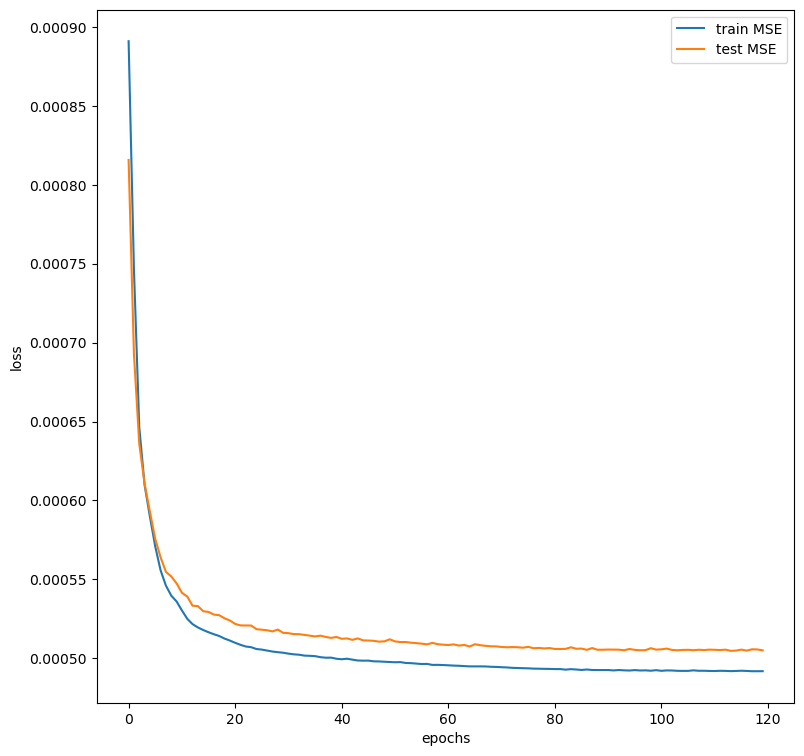

In [28]:
plt.figure(figsize = (9, 9))
plt.plot(list(train_history[e]['train_recon_loss'] for e in train_history.keys()), label = 'train MSE')
plt.plot(list(train_history[e]['test_recon_loss'] for e in train_history.keys()), label = 'test MSE')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(loc = "best")
plt.show()

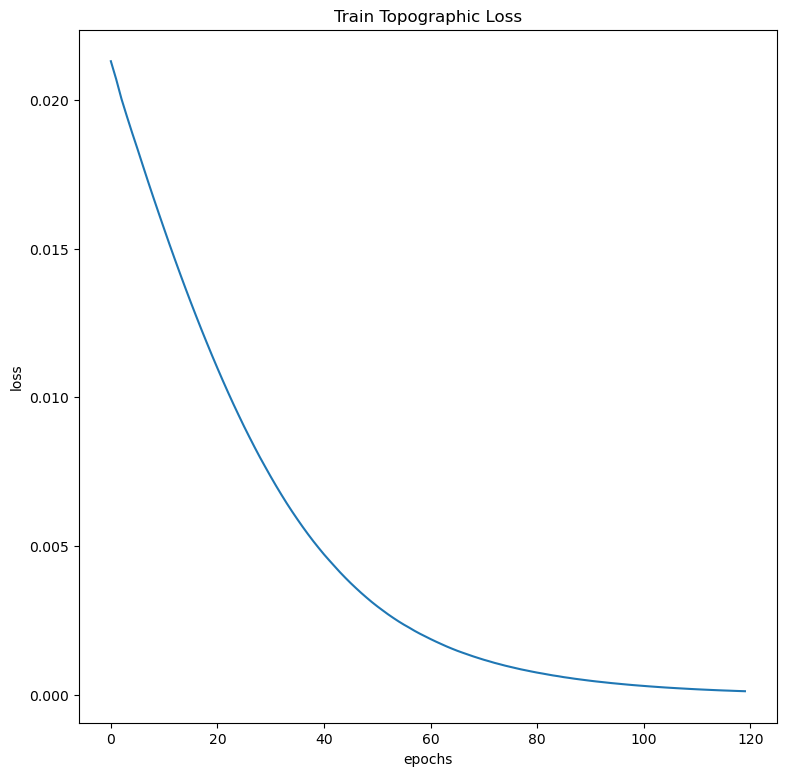

In [29]:
plt.figure(figsize = (9, 9))
plt.plot(list(train_history[e]['train_topo_loss'] * gamma for e in train_history.keys()))
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Train Topographic Loss")
plt.show()

In [30]:
x, _ = next(iter(test_loader))
x = x.to(device)

In [31]:
_, x_recon = model(x)

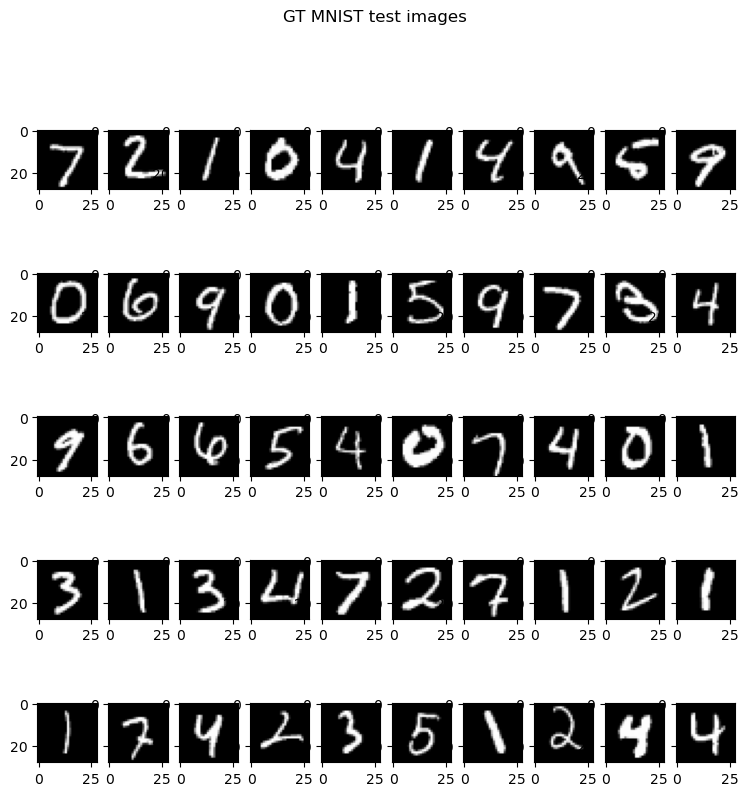

In [32]:
# Visualize 50 images from training set-
plt.figure(figsize = (9, 9))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(x.detach().cpu().numpy()[i][0], cmap = 'gray')
    
plt.suptitle("GT MNIST test images")
plt.show()

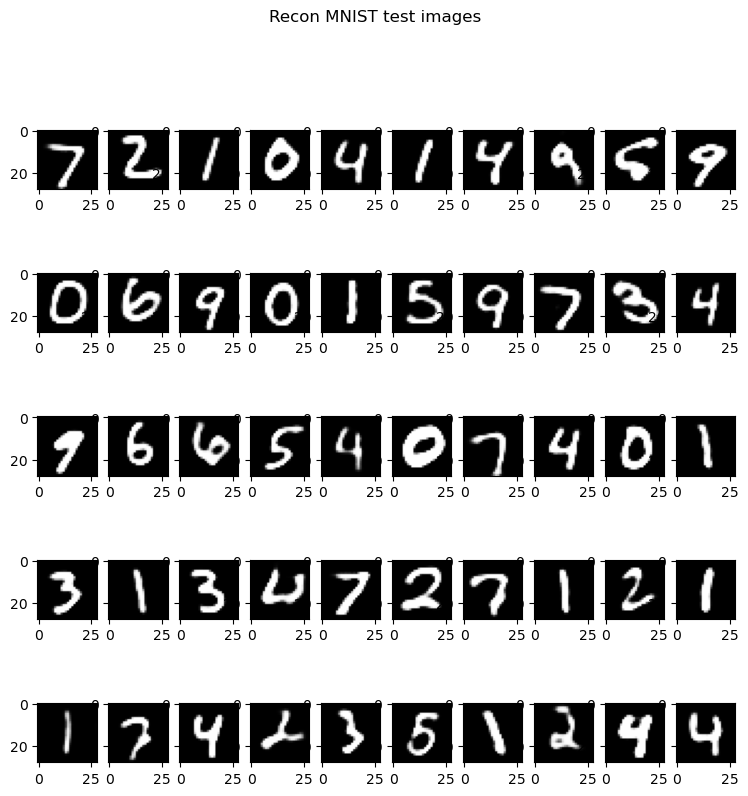

In [33]:
# Visualize 50 images from training set-
plt.figure(figsize = (9, 9))
for i in range(50):
    # 5 rows & 10 columns-
    plt.subplot(5, 10, i + 1)
    # plt.imshow(images[i], cmap = 'gray')
    # 0 to access first channel-
    plt.imshow(x_recon.detach().cpu().numpy()[i][0], cmap = 'gray')
    
plt.suptitle("Recon MNIST test images")
plt.show()

In [34]:
del x, x_recon

In [48]:
x, _ = next(iter(test_loader))
x = x.to(device)

In [49]:
z, _ = model(x)

In [50]:
l2_dist_z_soms = torch.cdist(x1 = z, x2 = model.som.som_wts.weight, p = p_norm)
mindist, bmu_indices = torch.min(l2_dist_z_soms, -1)
bmu_locations = locations[bmu_indices]

In [51]:
bmu_locations.shape, bmu_indices.shape

(torch.Size([1024, 2]), torch.Size([1024]))

In [53]:
vals, cnts = np.unique(ar = bmu_indices.detach().cpu().numpy(), return_counts = True)

/home/majumdar/anaconda3/envs/lightning_cuda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/majumdar/anaconda3/envs/lightning_cuda/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/majumdar/anaconda3/envs/lightning_cuda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/majumdar/anaconda3/envs/lightning_cuda/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na 

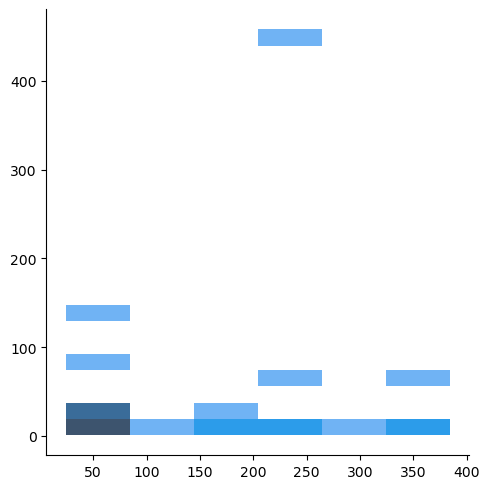

In [55]:
sns.displot(x = vals, y = cnts)
plt.show()

In [38]:
i = 0
for param in model.parameters():
    print(f"i = {i}, shape: {param.shape}")
    i += 1
del param

i = 0, shape: torch.Size([16, 1, 4, 4])
i = 1, shape: torch.Size([16])
i = 2, shape: torch.Size([32, 16, 4, 4])
i = 3, shape: torch.Size([32])
i = 4, shape: torch.Size([100, 1568])
i = 5, shape: torch.Size([100])
i = 6, shape: torch.Size([50, 100])
i = 7, shape: torch.Size([50])
i = 8, shape: torch.Size([100, 50])
i = 9, shape: torch.Size([100])
i = 10, shape: torch.Size([1568, 100])
i = 11, shape: torch.Size([1568])
i = 12, shape: torch.Size([32, 16, 4, 4])
i = 13, shape: torch.Size([16])
i = 14, shape: torch.Size([16, 1, 4, 4])
i = 15, shape: torch.Size([1])
i = 16, shape: torch.Size([400, 50])


In [35]:
som_trained_wts = list(model.parameters())[16]

In [36]:
som_trained_wts.min().item(), som_trained_wts.max().item()

(-0.14141587913036346, 0.14140239357948303)

In [37]:
model.som.som_wts.weight.min().item(), model.som.som_wts.weight.max().item()

(-0.14141587913036346, 0.14140239357948303)

In [38]:
model.som.som_wts.weight.requires_grad

True

In [40]:
# model.som.embedding.weight.shape
model.som.som_wts.weight.shape

torch.Size([400, 50])

In [43]:
# som_trained_wts = model.som.embedding.weight.detach().cpu()

In [41]:
som_trained_wts = som_trained_wts.view(som_height, som_height, -1)

In [42]:
som_trained_wts.shape

torch.Size([20, 20, 50])

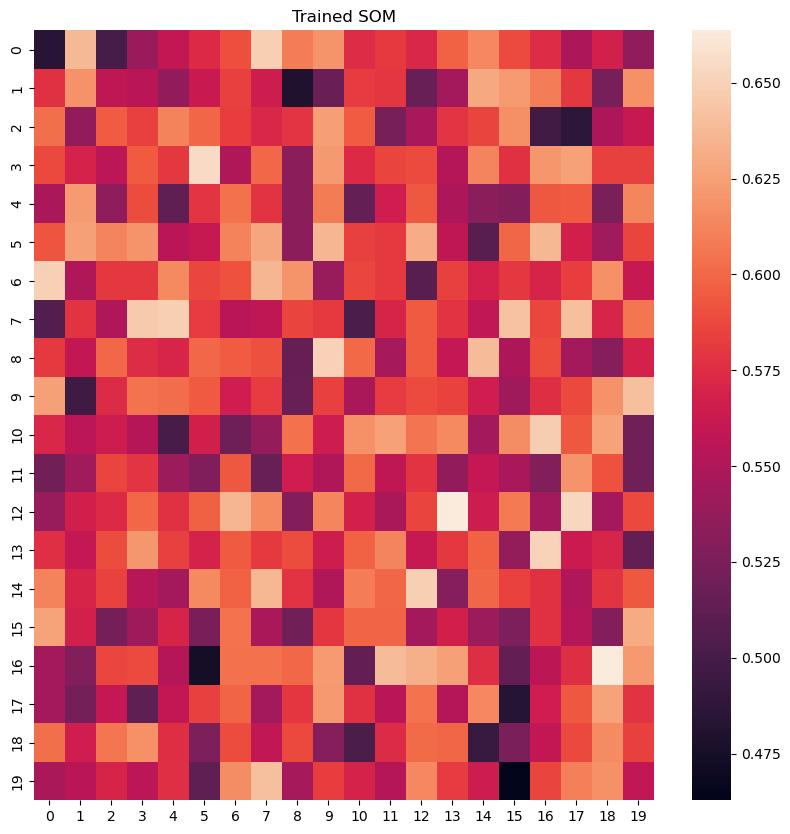

In [44]:
plt.figure(figsize = (10, 10))
# plt.imshow(torch.norm(input = som_trained_wts, p = 'fro', dim = 2), cmap = 'cividis')
sns.heatmap(data = torch.norm(input = som_trained_wts.detach().cpu(), p = 'fro', dim = 2))
plt.title("Trained SOM")
plt.show()

In [47]:
torch.all(som_trained_wts[0, 0] == som_trained_wts[0, 10])

tensor(False)

In [56]:
z = som_trained_wts[14, 14]

In [57]:
z = z.view(1, -1).to(device)

In [58]:
recon = model.decoder(z)

In [59]:
recon.shape

torch.Size([1, 1, 28, 28])

In [60]:
recon = torch.permute(recon, (0, 2, 3, 1))

In [61]:
recon.shape

torch.Size([1, 28, 28, 1])

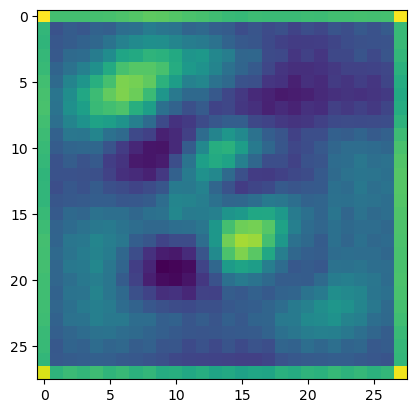

In [62]:
plt.imshow(recon[0].detach().cpu())
plt.show()